# Setup

## Installs

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import gpxpy
import folium

In [2]:
GPX_FILE_PATH = '../gpx/'
HARD_SLOPE_THRESHOLD = 0.2 # Threshold to consider a section as hard

colors = {
    'main': '#f53b57',
    'secondary': '#3c40c6',
    'tertiary': '#ffdd59',
}

In [3]:
plt.style.use('ggplot')

# Processing the GPX files

In [4]:
# Read the GPX file
gpx_file_name = 'tutan-itatiaia-100-2024.gpx'
full_gpx_file_path = os.path.join(GPX_FILE_PATH, gpx_file_name)
gpx_file = gpxpy.parse(open(full_gpx_file_path))

In [5]:
# Only extract the first track and segment
track = gpx_file.tracks[0]
segment = track.segments[0]
points = segment.points

# Extract information from points
coordinates = np.array([[point.latitude, point.longitude, point.elevation] for point in points]) #@!delete
df = (
    pd.DataFrame(
        coordinates,
        columns=['latitude', 'longitude', 'elevation']
    )
    .assign(
        # We add a 0 at the beginning to match the length of the DF
        elevation_diff=lambda x: np.concatenate(
            [[0], np.diff(x['elevation'])],
        )
    )
)

# Calculate the cumulative distances and slopes
distance_between_points_3d = np.zeros(len(points) - 1)
distance_between_points_2d = np.zeros(len(points) - 1)

for i in range(0, len(points) - 1):
    distance_between_points_3d[i] = gpxpy.geo.distance(
        df.iloc[i]['latitude'],  # latitude1
        df.iloc[i]['longitude'],  # longitude1
        df.iloc[i]['elevation'],  # elevation1
        df.iloc[i+1]['latitude'],   # latitude2
        df.iloc[i+1]['longitude'],   # longitude2
        df.iloc[i+1]['elevation'],    # elevation2
    )

    distance_between_points_2d[i] = gpxpy.geo.distance(
        df.iloc[i]['latitude'],  # latitude1
        df.iloc[i]['longitude'],  # longitude1
        0, # Set elevation to 0 for 2D distance
        df.iloc[i+1]['latitude'],   # latitude2
        df.iloc[i+1]['longitude'],   # longitude2
        0, # Set elevation to 0 for 2D distance
    )

# Bin the slopes - Define bin sizes and labels
slope_bins = np.arange(-1, 1, 0.1).round(2)
slope_bin_labels = [f"{round(100*slope_bins[i])} → {round(100*slope_bins[i+1])}%" for i in range(len(slope_bins) - 1)]

df = (
    df
    .assign(
        distance_between_points_3d=np.concatenate(
            [[0], distance_between_points_3d]
        ),
        distance_between_points_2d=np.concatenate(
            [[0], distance_between_points_2d]
        ),
        # Calculate cumulative distance and convert to km
        cum_distance_3d_km=np.concatenate(
            [[0], np.cumsum(distance_between_points_3d)/1000]
        ),
        cum_distance_2d_km=np.concatenate(
            [[0], np.cumsum(distance_between_points_2d)/1000]
        ),
        # # Calculate slope gradients
        slope_gradient=lambda x: x['elevation_diff']/x['distance_between_points_2d'],
        # Bin the slopes
        slope_bin=lambda x: pd.cut(
            x['slope_gradient'] + 0.0001,
            bins=slope_bins,
            right=False,
            labels=slope_bin_labels
        ),
        hard_slope=lambda x: abs(x['slope_gradient']) > HARD_SLOPE_THRESHOLD
    )
    .fillna(
        {
            'slope_gradient': 0,
            'slope_bin': '0 → 10%',
        }
    )
)

In [6]:
df

,latitude,longitude,elevation,elevation_diff,distance_between_points_3d,distance_between_points_2d,cum_distance_3d_km,cum_distance_2d_km,slope_gradient,slope_bin,hard_slope
0,-22.47597,-44.57797,462.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0 → 10%,False
1,-22.47583,-44.57827,462.0,0.0,34.571197,34.571197,0.034571,0.034571,0.000000,0 → 10%,False
2,-22.47550,-44.57887,463.0,1.0,71.830600,71.823639,0.106402,0.106395,0.013923,0 → 10%,False
3,-22.47536,-44.57912,467.0,4.0,30.334741,30.069860,0.136737,0.136465,0.133024,10 → 20%,False
4,-22.47517,-44.57941,468.0,1.0,36.581641,36.567970,0.173318,0.173033,0.027346,0 → 10%,False
...,...,...,...,...,...,...,...,...,...,...,...
2331,-22.32966,-44.53669,1023.0,0.0,35.450170,35.450170,94.707322,93.960828,0.000000,0 → 10%,False
2332,-22.32988,-44.53656,1020.0,-3.0,28.070782,27.910013,94.735393,93.988738,-0.107488,-20 → -10%,False
2333,-22.33027,-44.53680,1015.0,-5.0,50.205297,49.955699,94.785598,94.038694,-0.100089,-10 → 0%,False
2334,-22.33067,-44.53696,1015.0,0.0,47.478048,47.478048,94.833076,94.086172,0.000000,0 → 10%,False


# Plots

## Map

In [7]:
# Calculate the center of the route (based on the df)
center_coordinates = np.mean(
    df[['latitude', 'longitude']].values,
    axis=0
)

# Get basic statistics of the route
total_distance = segment.length_3d() # Total distance in meters
total_elevation_gain = segment.get_uphill_downhill().uphill
total_elevation_loss = segment.get_uphill_downhill().downhill

# Bounds of the route
min_lat = df['latitude'].min()
max_lat = df['latitude'].max()
min_lon = df['longitude'].min()
max_lon = df['longitude'].max()

# Create map with auto zoom based on bounds
map = folium.Map(
    location=center_coordinates,
    zoom_start=12,
)

# Fit bounds to the route
map.fit_bounds(
    [
        [min_lat, min_lon],  # Southwest corner
        [max_lat, max_lon]   # Northeast corner
    ]
)

# Add the route to the map
folium.PolyLine(
    df[['latitude', 'longitude']].values,
    weight=5,
    color=colors['main'],
    opacity=0.8
).add_to(map)

# Add the start and end points to the map
folium.Marker(
    location=df.iloc[0][['latitude', 'longitude']].values,
    icon=folium.Icon(color='green', icon='circle'),
).add_to(map)

folium.Marker(
    location=df.iloc[-1][['latitude', 'longitude']].values,
    icon=folium.Icon(color='red', icon='circle'),
).add_to(map)

# Display the map
map

In [8]:
print(f"Total distance: {total_distance/1000:.1f} km")
print(f"Total elevation gain: {round(total_elevation_gain):,} m")
print(f"Total elevation loss: {round(total_elevation_loss):,} m")
print(f"Total elevation gain / distance: {total_elevation_gain/total_distance:.3f}")

Total distance: 94.9 km
Total elevation gain: 4,225 m
Total elevation loss: 3,672 m
Total elevation gain / distance: 0.045


## Elevation profile

In [9]:
# Create the plot
fig = px.line(
    x=df['cum_distance_3d_km'],
    y=df['elevation'],
    title='Elevation Profile',
    labels={
        'x': 'Distance (km)',
        'y': 'Elevation (m)'
    }
)

fig.update_traces(
    line_color=colors['main'],
    line_width=2,
    fill='tonexty',
    fillcolor=f"rgba{tuple(int(colors['main'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) + (0.1,)}",
    mode='lines',
)

fig.update_layout(
    showlegend=False,
    plot_bgcolor='white',
    width=900,
    height=400,
    hoverdistance=100,     # Maximum distance to show hover effect
    spikedistance=100,     # Maximum distance to show spike
    yaxis=dict(
        range=[df['elevation'].min() - 50, df['elevation'].max() + 50],
        tickformat='.0f',  # Format y-axis ticks to 1 decimal place
        showline=True,
        showgrid=True,
        gridcolor='lightgrey',
        showspikes=True,         # Show spike line
        spikecolor=colors['main'],
        spikesnap='data',      # Spike snaps to data points
        spikemode='across',      # Spike goes across the plot
        spikethickness=1
    ),
    xaxis=dict(
        tickformat='.1f',  # Format x-axis ticks to 2 decimal places
        showline=True,
        showgrid=True,
        gridcolor='lightgrey',
        spikemode='across',
        spikesnap='data',
        spikethickness=1,
        spikecolor=colors['main']
    ),
    yaxis_title='Elevation (m)',
    xaxis_title='Distance (km)',
)

fig.show()

## Slope gradients

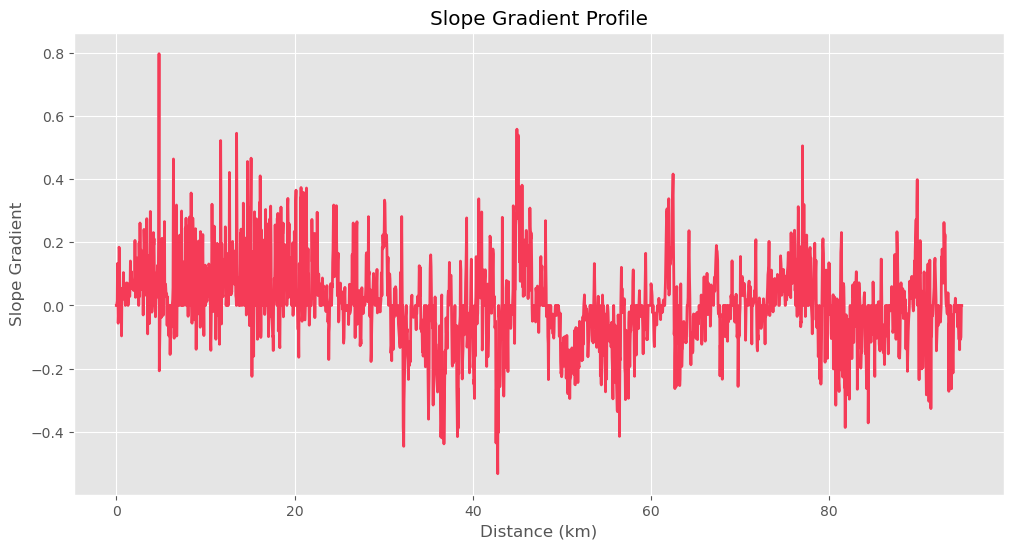

In [10]:
# Plot the slope gradients
plt.figure(figsize=(12, 6))
plt.plot(
    df['cum_distance_3d_km'],
    df['slope_gradient'],
    color=colors['main'],
    linewidth=2
)
plt.xlabel('Distance (km)')
plt.ylabel('Slope Gradient')
plt.title('Slope Gradient Profile')
plt.grid(True)
plt.show()

% of slopes with gradient > 0.2: 13.1%


/var/folders/q3/cbb_kmc13v1cvh7qwcdm3xs40000gn/T/ipykernel_49249/3290867969.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



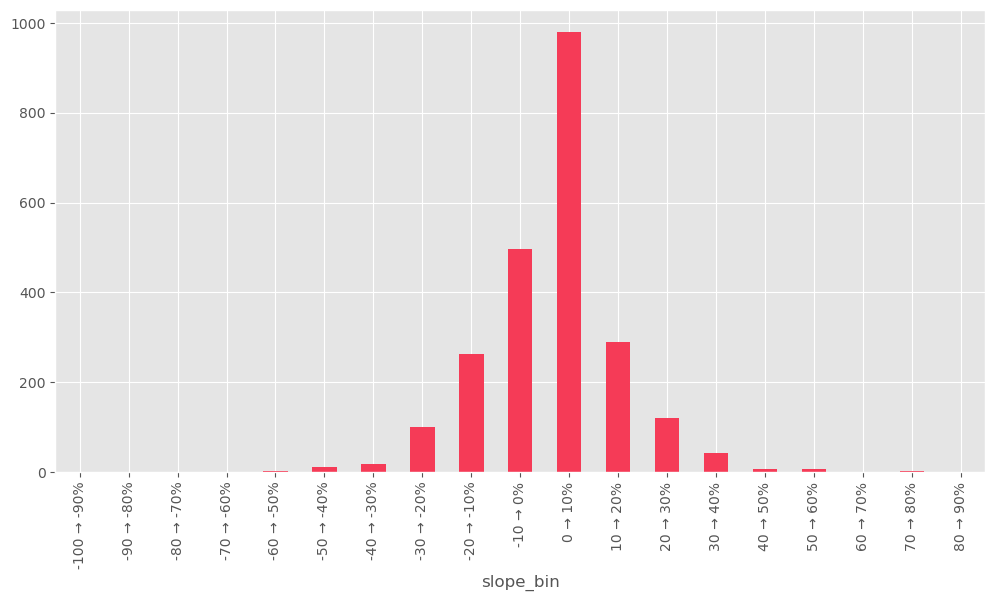

In [11]:
# Plot a histogram of the slope classifications
slope_df = (
    df
    .groupby('slope_bin')
    .size()
)

# % of hard slopes
hard_slope_perc = (
    (
        df
        .groupby('hard_slope')
        .size()/len(df)
    )
    .loc[True]
)

print(f"% of slopes with gradient > {HARD_SLOPE_THRESHOLD}: {100*hard_slope_perc:.1f}%")
# Plot the histogram
(
    slope_df
    .plot(
        kind='bar',
        color=colors['main'],
        figsize=(12, 6),
    )
);

# Route class refactor

In [12]:
from route import Route

GPX_FILE_PATH = '../gpx/'

# Read the GPX file
gpx_file_name = 'tutan-itatiaia-100-2024.gpx'
full_gpx_file_path = os.path.join(GPX_FILE_PATH, gpx_file_name)
route = Route(full_gpx_file_path)


In [13]:
# Test that basic attributes are loaded
print("Basic attributes test:")
print(f"Total distance: {route.total_distance/1000:.1f} km")
print(f"Total elevation gain: {round(route.elevation_gain):,} m")
print(f"Total elevation loss: {round(route.elevation_loss):,} m")
print(f"Average elevation gain per km: {round(route.avg_elevation_gain_per_km):,} m")
print(f"Route % of hard slopes (above {100*HARD_SLOPE_THRESHOLD:.0f}%): {100*route.hard_slope_percentage:.1f}%")

Basic attributes test:
Total distance: 94.9 km
Total elevation gain: 4,225 m
Total elevation loss: 3,672 m
Average elevation gain per km: 45 m
Route % of hard slopes (above 20%): 13.1%


In [14]:
# Plot the map
route_map = route.plot_map()
route_map

In [15]:
# Plot the elevation profile
elevation_profile = route.plot_elevation_profile()
elevation_profile


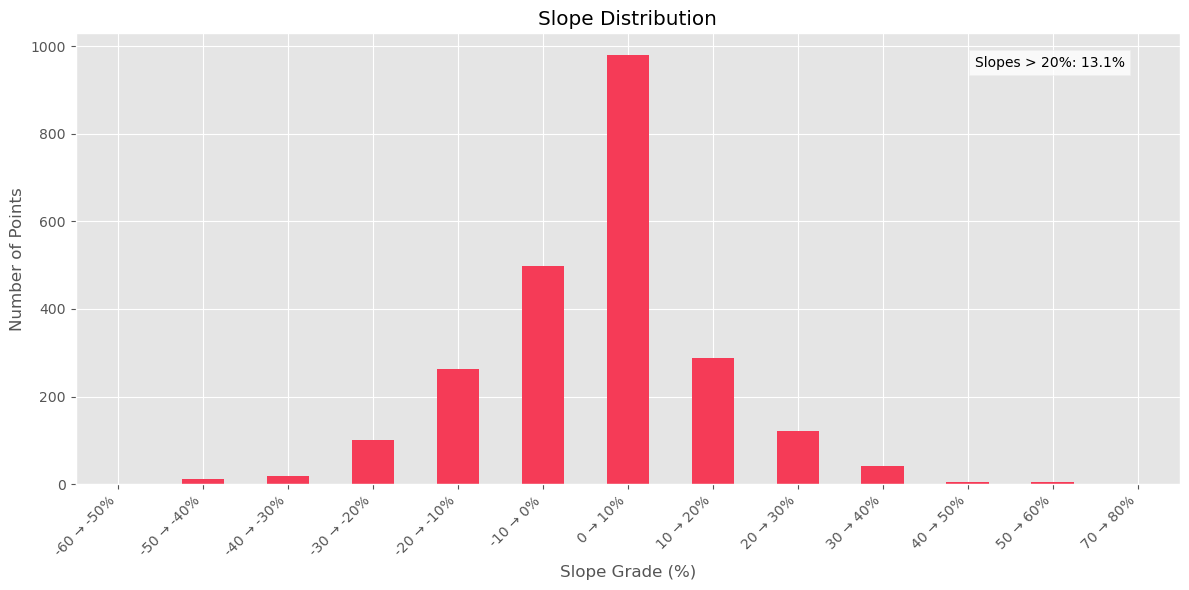

In [16]:
# Plot the slope histogram
slope_histogram = route.plot_slope_histogram()
slope_histogram

In [17]:
# Display the route's DataFrame
route.df

,latitude,longitude,elevation,elevation_diff,distance_between_points_3d,distance_between_points_2d,cum_distance_3d_km,cum_distance_2d_km,slope_gradient,slope_bin,hard_slope
0,-22.47597,-44.57797,462.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0 → 10%,False
1,-22.47583,-44.57827,462.0,0.0,34.571197,34.571197,0.034571,0.034571,0.000000,0 → 10%,False
2,-22.47550,-44.57887,463.0,1.0,71.830600,71.823639,0.106402,0.106395,0.013923,0 → 10%,False
3,-22.47536,-44.57912,467.0,4.0,30.334741,30.069860,0.136737,0.136465,0.133024,10 → 20%,False
4,-22.47517,-44.57941,468.0,1.0,36.581641,36.567970,0.173318,0.173033,0.027346,0 → 10%,False
...,...,...,...,...,...,...,...,...,...,...,...
2331,-22.32966,-44.53669,1023.0,0.0,35.450170,35.450170,94.707322,93.960828,0.000000,0 → 10%,False
2332,-22.32988,-44.53656,1020.0,-3.0,28.070782,27.910013,94.735393,93.988738,-0.107488,-20 → -10%,False
2333,-22.33027,-44.53680,1015.0,-5.0,50.205297,49.955699,94.785598,94.038694,-0.100089,-10 → 0%,False
2334,-22.33067,-44.53696,1015.0,0.0,47.478048,47.478048,94.833076,94.086172,0.000000,0 → 10%,False
